In [1]:
using Gync, JLD, Mamba
using ColorBrewer

In [2]:
thin = 1 # this is the load-thinning, do not confuse with computation-thinning

# datasets
fac20err10 = ["../out/fac20err10/$(p)_$c.jld" for c in 1:3, p in 1:3]
fac5err5   = ["../out/fac5err5/$(p)_$c.jld"   for c in 1:3, p in 1:3]
fac5err10(p, c) = ["../out/fac5err10/$(p)_$c.jld"  for c in c, p in p]

files = fac5err10(1:5, 1:3)

lengths = map(f->jldopen(file->size(file["chains"],1), f, "r"), files)

3x13 Array{Int64,2}:
 100000  100000  100000  100000  100000  …  39000  54000  35000  41000  53000
 100000  100000  100000  100000  100000     38000  54000  36000  39000  50000
 100000  100000  100000  100000  100000     40000  53000  36000  42000  42000

In [3]:
alldata = map((f,l)->load(f)["chains"][1:thin:l, :, :], files, lengths)

In [69]:
allchains  = cat(3, alldata...)[1:end,:,:]
allpersons = cat(3,[vcat(alldata[:,p]...) for p=1:P]...)[1:C:end,:,:]
all        = vcat(alldata...)[1:C*P:end,:,:]

100000x115x1 Array{Float64,3}:
[:, :, 1] =
  6317.93   7727.02  169.272   2.32505  …  2.61772e-5   2.76033e-5 
  6304.51   8745.01  170.336   2.27756     2.62028e-5   2.63331e-5 
  7694.97  10483.4   212.085   2.4052      3.03257e-5   1.98991e-5 
 10099.9   10086.9   244.817   2.27636     3.04233e-5   1.58689e-5 
  9827.41   7802.0   276.974   2.64605     3.27338e-5   1.63929e-5 
 10458.8    7422.13  342.092   2.59896  …  3.127e-5     1.53212e-5 
 12387.9    8676.69  335.265   2.33264     2.54226e-5   1.3857e-5  
 13224.4    8168.89  308.917   2.03161     2.67997e-5   1.83166e-5 
 12400.3    7528.04  291.59    2.3314      2.72314e-5   1.83108e-5 
 10117.1    7222.84  292.482   1.93169     3.15511e-5   2.36628e-5 
 10023.5    7063.82  350.181   2.3605   …  3.67841e-5   2.72028e-5 
 10582.3    6577.05  389.155   2.48474     3.8795e-5    2.99711e-5 
 10233.2    5647.06  410.472   2.3192      3.0271e-5    2.98996e-5 
     ⋮                                  ⋱                          
  369

In [70]:
data = cat(3,allpersons)

mcs = Chains(data, names=[Gync.parameternames[Gync.sampleparms]; Gync.speciesnames])

println("size: ", size(mcs))
#println("acc:  ", map(x->round(x,3),acceptance(mcs)))

size: (100000,115,5)


In [117]:
# print all sampled names
for (i,v) in enumerate(Gync.samplednames)
    print(i, " ",v)
end

1 basal LH synthesis rate constant
2 E2 promoted LH synthesis rate constant
3 threshold of E2
4 threshold of P4
5 basal LH release rate constant
6 infuence of GnRH receptor complex on LH release
7 threshold of GnRH on LH release rate
8 blood volume
9 binding rate of LH to its receptor
10 clearance rate of LH from the blood
11 formation rate of free LH receptors
12 desensitization rate of LH receptor complex
13 basal FSH synthesis rate constant
14 threshold of Inhibin A in FSH synthesis
15 threshold of Inhibin B in FSH synthesis
16 threshold of FSH (former GnRH?!) frequency
17 basal FSH release rate constant
18 stimulation of FSH release by GnRH receptor complex
19 threshold of GnRH on FSH release rate
20 binding rate of FSH to its receptor
21 clearance rate of FSH from the blood
22 formation rate of free FSH receptors
23 desensitization rate of FSH receptor complex
24 synthesis rate constant of LH receptors on granulosa cells
25 threshold of FSH-R to stimulate LH receptors on granulosa

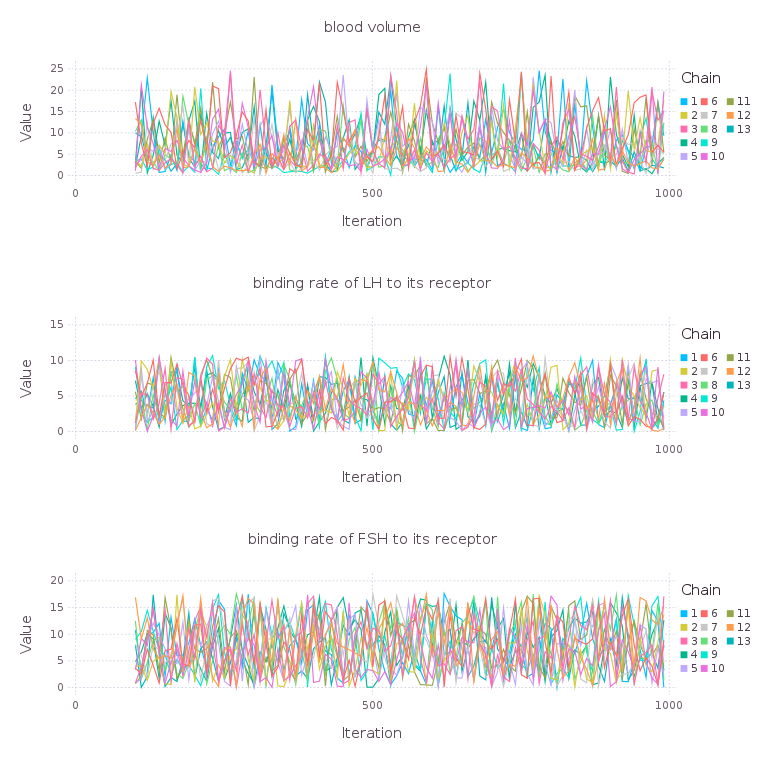

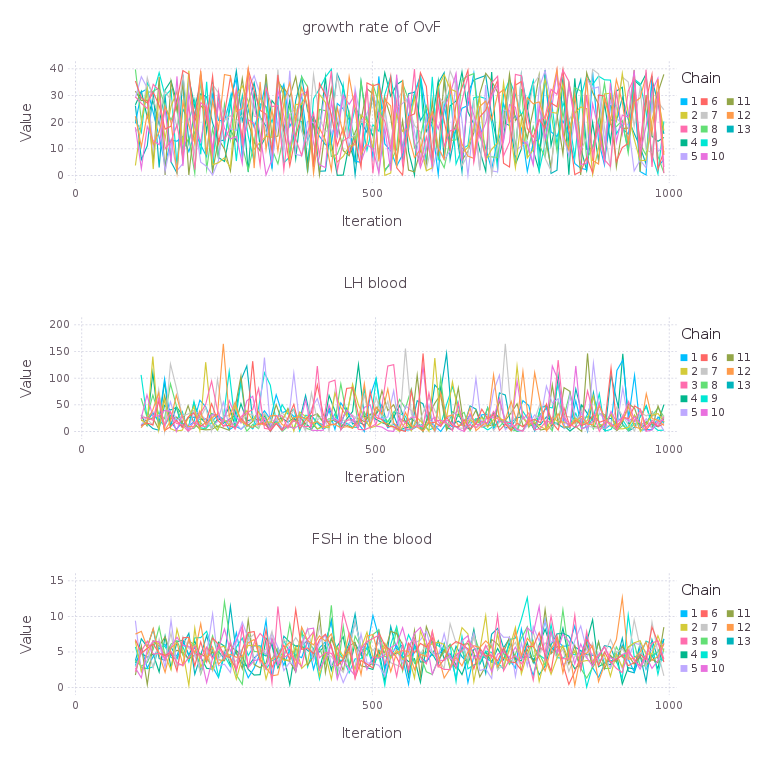

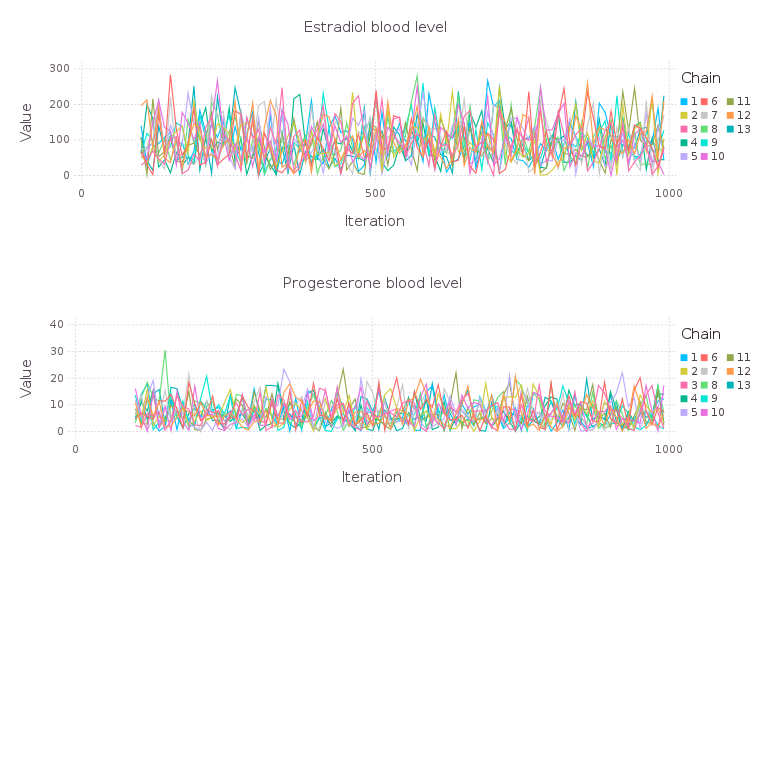

5.266842 seconds (5.65 M allocations: 243.172 MB, 2.84% gc time)
 22

In [59]:
plotspecies = [8, 9, 20, 39, 84, 89, 106, 107]
#plotspecies = Colon()
burnin = 10_000 / thin |> Int
types = [:trace, :autocor, :mean, :density]
#types = [:density]
types = [:trace]#, :autocor, :mean]
step = 10
@time plots = plot(mcs[burnin+1:step:end,plotspecies,:], types, trim=(0,1), legend=true)

@time draw(plots, ask=false, fmt=:png, ncol=length(types))

In [71]:
import Gync: sampledmles
using Gadfly: layer, Geom
using ColorBrewer

addmle!(plot::Gadfly.Plot, species::Int) = push!(plot, layer(Geom.vline, xintercept=[Gync.sampledmles[species]]))

function analyse(mcs)
    [analyse_single(mcs[:,i,:]) for i = 1:size(mcs,2)]
end

function analyse_single(mc)
    size(mc,2) == 1 || error("chain contains multiple variables")
    const plotresolution = 20_000
    
    step = max(round(Int, size(mc, 1) / plotresolution), 1)
    p = plot(mc[1:step:end,:,:], :density, trim=(0,1), legend=true, format=:PNG)[1]
    species = findnext(Gync.samplednames, mc.names[1],1)
    addmle!(p, species)
    
    colors = vcat(map(c->palette(c, 6)[3:5], ["GnBu", "Greys", "Oranges"])...)
    push!(p, Gadfly.Scale.color_discrete_manual(colors...))

    
    gelman = gelmandiag(mc[:,:,:])
    println("Gelman Rubin (PSRF, 97.5%): ", string(gelman.value))
    display(p)
    p
end

plots = analyse(mcs[burnin:step:end,plotspecies,:]);

Gelman Rubin (PSRF, 97.5%): [1.072 1.18]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 -50 
 0 
 50 
 100 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M42.05,78.71 L 42.3 78.71 42.55 78.71 42.79 78.71 43.04 78.71 43.28 78.71 43.53 78.7 43.78 78.7 44.02 78.68 44.27 78.66 44.51 78.62 44.76 78.56 45.01 78.48 45.25 78.34 45.5 78.14 45.74 77.86 45.99 77.46 46.23 76.92 46.48 76.19 46.73 75.24 46.97 74.03 47.22 72.51 47.46 70.67 47.71 68.48 47.96 65.93 48.2 63.04 48.45 59.84 48.69 56.38 48.94 52.72 49.19 48.96 49.43 45.18 49.68 41.48 49.92 37.95 50.17 34.67 50.42 31.73 50.66 29.16 50.91 27 51.15 25.26 51.4 23.94 51.64 23.03 51.89 22.48 52.14 22.26 52.38 22.32 52.63 22.62 52.87 23.11 53.12 23.76 53.37 24.53 53.61 25.38 53.86 26.29 54.1 27.25 54.35 28.22 54.6 29.22 54.84 30.22 55.09 31.22 55.33 32.23 55.58 33.23 55.83 34.25 56.07 35.26 56.32 36.28 56.56 37.3 56.81 38.33 57.06 39.36 57.3 40.4 57.55 41.44 57.79 42.5 58.04 43.56 58.28 44.63 58.53 45.7 58.78 46.78 59.02 47.84 59.27 48.89 59.51 49.91 59.76 50.89 60.01 51.82 60.25 52.69 60.5 53.5 60.74 54.25 60.99 54.93 61.24 55.56 61.48 56.14 61.73 56.68 61.97 57.2 62.22 57.71 62.47 58.2 62.71 58.7 62.96 59.21 63.2 59.72 63.45 60.23 63.69 60.75 63.94 61.25 64.19 61.75 64.43 62.23 64.68 62.7 64.92 63.14 65.17 63.57 65.42 63.97 65.66 64.36 65.91 64.74 66.15 65.12 66.4 65.49 66.65 65.87 66.89 66.26 67.14 66.65 67.38 67.04 67.63 67.44 67.88 67.82 68.12 68.18 68.37 68.52 68.61 68.83 68.86 69.11 69.1 69.36 69.35 69.57 69.6 69.76 69.84 69.93 70.09 70.08 70.33 70.23 70.58 70.39 70.83 70.56 71.07 70.74 71.32 70.95 71.56 71.17 71.81 71.41 72.06 71.65 72.3 71.9 72.55 72.14 72.79 72.37 73.04 72.57 73.29 72.75 73.53 72.9 73.78 73.01 74.02 73.1 74.27 73.17 74.52 73.21 74.76 73.25 75.01 73.28 75.25 73.31 75.5 73.34 75.74 73.38 75.99 73.44 76.24 73.51 76.48 73.59 76.73 73.68 76.97 73.79 77.22 73.9 77.47 74.03 77.71 74.16 77.96 74.29 78.2 74.42 78.45 74.55 78.7 74.68 78.94 74.8 79.19 74.92 79.43 75.03 79.68 75.12 79.93 75.21 80.17 75.28 80.42 75.35 80.66 75.4 80.91 75.44 81.15 75.48 81.4 75.5 81.65 75.53 81.89 75.55 82.14 75.57 82.38 75.58 82.63 75.6 82.88 75.63 83.12 75.66 83.37 75.69 83.61 75.74 83.86 75.79 84.11 75.86 84.35 75.94 84.6 76.03 84.84 76.13 85.09 76.24 85.34 76.37 85.58 76.49 85.83 76.62 86.07 76.75 86.32 76.87 86.56 76.98 86.81 77.07 87.06 77.15 87.3 77.21 87.55 77.26 87.79 77.29 88.04 77.3 88.29 77.31 88.53 77.3 88.78 77.28 89.02 77.27 89.27 77.25 89.52 77.22 89.76 77.2 90.01 77.19 90.25 77.17 90.5 77.16 90.75 77.15 90.99 77.14 91.24 77.14 91.48 77.14 91.73 77.15 91.98 77.16 92.22 77.18 92.47 77.21 92.71 77.24 92.96 77.28 93.2 77.32 93.45 77.36 93.7 77.4 93.94 77.45 94.19 77.49 94.43 77.54 94.68 77.58 94.93 77.62 95.17 77.65 95.42 77.68 95.66 77.71 95.91 77.73 96.16 77.74 96.4 77.75 96.65 77.74 96.89 77.74 97.14 77.72 97.39 77.7 97.63 77.68 97.88 77.66 98.12 77.63 98.37 77.61 98.61 77.59 98.86 77.57 99.11 77.55 99.35 77.54 99.6 77.53 99.84 77.53 100.09 77.53 100.34 77.54 100.58 77.55 100.83 77.57 101.07 77.5


Gelman Rubin (PSRF, 97.5%): [1.001 1.003]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 -40 
 -20 
 0 
 20 
 40 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M35.92,78.71 L 36.18 78.71 36.45 78.71 36.71 78.71 36.98 78.71 37.24 78.71 37.51 78.7 37.77 78.7 38.04 78.69 38.3 78.68 38.57 78.67 38.83 78.65 39.1 78.63 39.36 78.6 39.63 78.57 39.89 78.52 40.16 78.46 40.42 78.39 40.69 78.3 40.95 78.19 41.22 78.05 41.48 77.88 41.75 77.68 42.01 77.44 42.28 77.15 42.54 76.8 42.8 76.4 43.07 75.93 43.33 75.39 43.6 74.77 43.86 74.06 44.13 73.26 44.39 72.37 44.66 71.38 44.92 70.29 45.19 69.09 45.45 67.79 45.72 66.39 45.98 64.9 46.25 63.32 46.51 61.65 46.78 59.92 47.04 58.12 47.31 56.28 47.57 54.4 47.84 52.5 48.1 50.61 48.37 48.72 48.63 46.86 48.9 45.05 49.16 43.29 49.43 41.6 49.69 39.99 49.96 38.46 50.22 37.03 50.48 35.7 50.75 34.47 51.01 33.35 51.28 32.33 51.54 31.41 51.81 30.58 52.07 29.85 52.34 29.21 52.6 28.65 52.87 28.16 53.13 27.75 53.4 27.39 53.66 27.1 53.93 26.86 54.19 26.67 54.46 26.52 54.72 26.42 54.99 26.36 55.25 26.34 55.52 26.36 55.78 26.41 56.05 26.51 56.31 26.63 56.58 26.8 56.84 27 57.11 27.22 57.37 27.48 57.64 27.77 57.9 28.09 58.17 28.43 58.43 28.78 58.69 29.16 58.96 29.54 59.22 29.94 59.49 30.34 59.75 30.74 60.02 31.14 60.28 31.54 60.55 31.92 60.81 32.3 61.08 32.66 61.34 33 61.61 33.33 61.87 33.64 62.14 33.94 62.4 34.21 62.67 34.47 62.93 34.71 63.2 34.92 63.46 35.13 63.73 35.31 63.99 35.48 64.26 35.63 64.52 35.77 64.79 35.89 65.05 36 65.32 36.09 65.58 36.17 65.85 36.24 66.11 36.3 66.38 36.35 66.64 36.39 66.9 36.42 67.17 36.45 67.43 36.48 67.7 36.5 67.96 36.53 68.23 36.56 68.49 36.59 68.76 36.64 69.02 36.69 69.29 36.75 69.55 36.83 69.82 36.92 70.08 37.03 70.35 37.16 70.61 37.3 70.88 37.47 71.14 37.65 71.41 37.84 71.67 38.05 71.94 38.28 72.2 38.51 72.47 38.76 72.73 39.01 73 39.26 73.26 39.51 73.53 39.76 73.79 40 74.06 40.23 74.32 40.45 74.58 40.66 74.85 40.86 75.11 41.04 75.38 41.2 75.64 41.35 75.91 41.48 76.17 41.6 76.44 41.72 76.7 41.82 76.97 41.92 77.23 42.02 77.5 42.13 77.76 42.24 78.03 42.36 78.29 42.49 78.56 42.64 78.82 42.81 79.09 43 79.35 43.21 79.62 43.45 79.88 43.71 80.15 43.99 80.41 44.29 80.68 44.61 80.94 44.95 81.21 45.3 81.47 45.66 81.74 46.03 82 46.41 82.27 46.78 82.53 47.15 82.79 47.51 83.06 47.86 83.32 48.19 83.59 48.5 83.85 48.79 84.12 49.05 84.38 49.29 84.65 49.5 84.91 49.68 85.18 49.84 85.44 49.96 85.71 50.06 85.97 50.13 86.24 50.19 86.5 50.22 86.77 50.23 87.03 50.24 87.3 50.23 87.56 50.22 87.83 50.21 88.09 50.2 88.36 50.2 88.62 50.21 88.89 50.23 89.15 50.26 89.42 50.32 89.68 50.39 89.95 50.48 90.21 50.59 90.48 50.71 90.74 50.86 91 51.02 91.27 51.19 91.53 51.38 91.8 51.57 92.06 51.77 92.33 51.97 92.59 52.18 92.86 52.38 93.12 52.58 93.39 52.77 93.65 52.96 93.92 53.14 94.18 53.31 94.45 53.48 94.71 53.64 94.98 53.8 95.24 53.95 95.51 54.1 95.77 54.25 96.04 54.4 96.3 54.56 96.57 54.72 96.83 54.9 97.1 55.1 97.36 55.31 97.63 55.55 97.89 55.81 98.16 56.1 98.42 56.42 98.68 56.77 98.95 57.16 99.21 57.59 99.48 58.05 99.74 58.56 100.01 59.11 100.27 5


Gelman Rubin (PSRF, 97.5%): [1.004 1.012]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 -50 
 0 
 50 
 100 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M37.82,78.71 L 38.04 78.71 38.26 78.71 38.48 78.71 38.7 78.71 38.92 78.71 39.14 78.71 39.36 78.7 39.58 78.7 39.8 78.69 40.02 78.68 40.23 78.67 40.45 78.66 40.67 78.64 40.89 78.62 41.11 78.59 41.33 78.55 41.55 78.51 41.77 78.45 41.99 78.38 42.21 78.29 42.43 78.18 42.65 78.05 42.87 77.9 43.09 77.72 43.31 77.5 43.52 77.24 43.74 76.94 43.96 76.6 44.18 76.2 44.4 75.74 44.62 75.22 44.84 74.64 45.06 73.98 45.28 73.26 45.5 72.46 45.72 71.58 45.94 70.62 46.16 69.59 46.38 68.47 46.6 67.29 46.81 66.03 47.03 64.71 47.25 63.33 47.47 61.9 47.69 60.42 47.91 58.9 48.13 57.36 48.35 55.8 48.57 54.23 48.79 52.66 49.01 51.11 49.23 49.57 49.45 48.07 49.67 46.61 49.89 45.19 50.11 43.82 50.32 42.52 50.54 41.27 50.76 40.09 50.98 38.98 51.2 37.94 51.42 36.97 51.64 36.06 51.86 35.22 52.08 34.44 52.3 33.73 52.52 33.08 52.74 32.48 52.96 31.93 53.18 31.43 53.4 30.97 53.61 30.56 53.83 30.19 54.05 29.85 54.27 29.55 54.49 29.28 54.71 29.04 54.93 28.83 55.15 28.64 55.37 28.49 55.59 28.36 55.81 28.26 56.03 28.18 56.25 28.12 56.47 28.09 56.69 28.08 56.9 28.1 57.12 28.13 57.34 28.19 57.56 28.27 57.78 28.37 58 28.49 58.22 28.63 58.44 28.78 58.66 28.96 58.88 29.15 59.1 29.36 59.32 29.59 59.54 29.83 59.76 30.08 59.98 30.35 60.19 30.63 60.41 30.92 60.63 31.22 60.85 31.52 61.07 31.82 61.29 32.13 61.51 32.43 61.73 32.73 61.95 33.03 62.17 33.31 62.39 33.59 62.61 33.86 62.83 34.11 63.05 34.35 63.27 34.57 63.48 34.78 63.7 34.98 63.92 35.16 64.14 35.33 64.36 35.48 64.58 35.62 64.8 35.76 65.02 35.88 65.24 35.99 65.46 36.1 65.68 36.2 65.9 36.31 66.12 36.4 66.34 36.5 66.56 36.6 66.77 36.7 66.99 36.79 67.21 36.89 67.43 36.99 67.65 37.09 67.87 37.19 68.09 37.28 68.31 37.37 68.53 37.46 68.75 37.54 68.97 37.6 69.19 37.66 69.41 37.7 69.63 37.73 69.85 37.74 70.06 37.73 70.28 37.7 70.5 37.65 70.72 37.58 70.94 37.5 71.16 37.39 71.38 37.27 71.6 37.13 71.82 36.98 72.04 36.82 72.26 36.66 72.48 36.49 72.7 36.32 72.92 36.16 73.14 36.01 73.35 35.86 73.57 35.74 73.79 35.63 74.01 35.55 74.23 35.49 74.45 35.45 74.67 35.44 74.89 35.46 75.11 35.51 75.33 35.58 75.55 35.67 75.77 35.79 75.99 35.93 76.21 36.09 76.43 36.26 76.65 36.44 76.86 36.63 77.08 36.82 77.3 37 77.52 37.18 77.74 37.35 77.96 37.5 78.18 37.63 78.4 37.74 78.62 37.83 78.84 37.9 79.06 37.94 79.28 37.95 79.5 37.94 79.72 37.91 79.94 37.86 80.15 37.78 80.37 37.7 80.59 37.6 80.81 37.5 81.03 37.4 81.25 37.3 81.47 37.21 81.69 37.13 81.91 37.08 82.13 37.04 82.35 37.03 82.57 37.04 82.79 37.09 83.01 37.16 83.23 37.26 83.44 37.39 83.66 37.54 83.88 37.72 84.1 37.91 84.32 38.13 84.54 38.35 84.76 38.58 84.98 38.82 85.2 39.05 85.42 39.28 85.64 39.51 85.86 39.72 86.08 39.93 86.3 40.12 86.52 40.3 86.73 40.47 86.95 40.63 87.17 40.78 87.39 40.93 87.61 41.08 87.83 41.24 88.05 41.41 88.27 41.6 88.49 41.81 88.71 42.06 88.93 42.34 89.15 42.67 89.37 43.04 89.59 43.48 89.81 43.97 90.02 44.53 90.24 45.16 90.46 45.


Gelman Rubin (PSRF, 97.5%): [1.003 1.01]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -80 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 -70 
 -68 
 -66 
 -64 
 -62 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 102 
 104 
 106 
 108 
 110 
 -100 
 0 
 100 
 200 
 -70 
 -65 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 105 
 110 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M24.29,78.71 L 24.62 78.71 24.95 78.71 25.28 78.71 25.61 78.71 25.94 78.71 26.27 78.71 26.6 78.71 26.93 78.7 27.26 78.7 27.59 78.69 27.92 78.68 28.25 78.67 28.58 78.66 28.91 78.64 29.24 78.62 29.57 78.59 29.9 78.55 30.23 78.5 30.55 78.45 30.88 78.38 31.21 78.29 31.54 78.19 31.87 78.06 32.2 77.91 32.53 77.74 32.86 77.53 33.19 77.29 33.52 77.01 33.85 76.69 34.18 76.33 34.51 75.92 34.84 75.46 35.17 74.94 35.5 74.37 35.83 73.75 36.16 73.07 36.49 72.34 36.82 71.55 37.15 70.72 37.48 69.84 37.81 68.92 38.14 67.96 38.46 66.97 38.79 65.96 39.12 64.93 39.45 63.89 39.78 62.86 40.11 61.83 40.44 60.81 40.77 59.81 41.1 58.84 41.43 57.91 41.76 57.01 42.09 56.15 42.42 55.34 42.75 54.57 43.08 53.85 43.41 53.18 43.74 52.55 44.07 51.97 44.4 51.43 44.73 50.94 45.06 50.48 45.39 50.06 45.72 49.68 46.05 49.32 46.38 49 46.7 48.7 47.03 48.42 47.36 48.16 47.69 47.93 48.02 47.71 48.35 47.5 48.68 47.32 49.01 47.14 49.34 46.98 49.67 46.83 50 46.69 50.33 46.57 50.66 46.45 50.99 46.33 51.32 46.23 51.65 46.13 51.98 46.04 52.31 45.96 52.64 45.88 52.97 45.8 53.3 45.73 53.63 45.66 53.96 45.59 54.29 45.52 54.61 45.46 54.94 45.39 55.27 45.32 55.6 45.25 55.93 45.17 56.26 45.09 56.59 44.99 56.92 44.89 57.25 44.77 57.58 44.64 57.91 44.5 58.24 44.34 58.57 44.16 58.9 43.96 59.23 43.75 59.56 43.51 59.89 43.27 60.22 43 60.55 42.73 60.88 42.44 61.21 42.15 61.54 41.86 61.87 41.57 62.2 41.29 62.53 41.01 62.85 40.75 63.18 40.51 63.51 40.29 63.84 40.1 64.17 39.93 64.5 39.8 64.83 39.69 65.16 39.62 65.49 39.58 65.82 39.57 66.15 39.59 66.48 39.64 66.81 39.72 67.14 39.82 67.47 39.94 67.8 40.07 68.13 40.22 68.46 40.38 68.79 40.54 69.12 40.7 69.45 40.87 69.78 41.02 70.11 41.18 70.44 41.32 70.76 41.45 71.09 41.56 71.42 41.67 71.75 41.75 72.08 41.82 72.41 41.87 72.74 41.91 73.07 41.93 73.4 41.93 73.73 41.92 74.06 41.9 74.39 41.86 74.72 41.81 75.05 41.75 75.38 41.68 75.71 41.6 76.04 41.52 76.37 41.42 76.7 41.31 77.03 41.19 77.36 41.06 77.69 40.92 78.02 40.77 78.35 40.61 78.68 40.43 79 40.23 79.33 40.02 79.66 39.8 79.99 39.56 80.32 39.3 80.65 39.02 80.98 38.73 81.31 38.43 81.64 38.12 81.97 37.8 82.3 37.47 82.63 37.14 82.96 36.81 83.29 36.49 83.62 36.17 83.95 35.87 84.28 35.58 84.61 35.3 84.94 35.05 85.27 34.82 85.6 34.61 85.93 34.43 86.26 34.27 86.59 34.14 86.91 34.04 87.24 33.96 87.57 33.91 87.9 33.88 88.23 33.88 88.56 33.89 88.89 33.92 89.22 33.98 89.55 34.04 89.88 34.12 90.21 34.22 90.54 34.32 90.87 34.43 91.2 34.55 91.53 34.67 91.86 34.8 92.19 34.93 92.52 35.06 92.85 35.2 93.18 35.33 93.51 35.46 93.84 3


Gelman Rubin (PSRF, 97.5%): [1.0 1.001]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 -300 
 -290 
 -280 
 -270 
 -260 
 -250 
 -240 
 -230 
 -220 
 -210 
 -200 
 -190 
 -180 
 -170 
 -160 
 -150 
 -140 
 -130 
 -120 
 -110 
 -100 
 -90 
 -80 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 140 
 150 
 160 
 170 
 180 
 190 
 200 
 210 
 220 
 230 
 240 
 250 
 260 
 270 
 280 
 290 
 300 
 310 
 320 
 330 
 340 
 350 
 360 
 370 
 380 
 390 
 400 
 410 
 420 
 430 
 440 
 450 
 -500 
 0 
 500 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M37,78.71 L 37.28 78.71 37.56 78.71 37.84 78.7 38.12 78.69 38.4 78.67 38.68 78.63 38.96 78.57 39.24 78.46 39.52 78.28 39.79 78.01 40.07 77.6 40.35 77 40.63 76.18 40.91 75.08 41.19 73.66 41.47 71.88 41.75 69.74 42.03 67.26 42.31 64.49 42.59 61.51 42.87 58.4 43.15 55.28 43.43 52.26 43.71 49.44 43.99 46.89 44.27 44.66 44.55 42.79 44.83 41.27 45.11 40.08 45.38 39.2 45.66 38.58 45.94 38.19 46.22 37.99 46.5 37.95 46.78 38.05 47.06 38.26 47.34 38.55 47.62 38.91 47.9 39.32 48.18 39.76 48.46 40.2 48.74 40.65 49.02 41.1 49.3 41.56 49.58 42.03 49.86 42.53 50.14 43.09 50.42 43.7 50.7 44.39 50.98 45.16 51.25 45.99 51.53 46.88 51.81 47.8 52.09 48.72 52.37 49.62 52.65 50.49 52.93 51.31 53.21 52.06 53.49 52.77 53.77 53.42 54.05 54.04 54.33 54.64 54.61 55.22 54.89 55.8 55.17 56.4 55.45 57 55.73 57.63 56.01 58.27 56.29 58.93 56.57 59.59 56.85 60.24 57.12 60.89 57.4 61.51 57.68 62.11 57.96 62.68 58.24 63.24 58.52 63.77 58.8 64.3 59.08 64.83 59.36 65.37 59.64 65.91 59.92 66.47 60.2 67.02 60.48 67.57 60.76 68.09 61.04 68.59 61.32 69.05 61.6 69.46 61.88 69.84 62.16 70.19 62.44 70.52 62.71 70.83 62.99 71.15 63.27 71.47 63.55 71.81 63.83 72.16 64.11 72.52 64.39 72.88 64.67 73.23 64.95 73.57 65.23 73.89 65.51 74.17 65.79 74.42 66.07 74.63 66.35 74.81 66.63 74.95 66.91 75.05 67.19 75.14 67.47 75.2 67.75 75.26 68.03 75.3 68.31 75.35 68.58 75.4 68.86 75.45 69.14 75.5 69.42 75.56 69.7 75.63 69.98 75.7 70.26 75.77 70.54 75.85 70.82 75.93 71.1 76.01 71.38 76.09 71.66 76.16 71.94 76.24 72.22 76.32 72.5 76.4 72.78 76.47 73.06 76.54 73.34 76.62 73.62 76.69 73.9 76.77 74.18 76.85 74.45 76.94 74.73 77.04 75.01 77.13 75.29 77.23 75.57 77.34 75.85 77.44 76.13 77.53 76.41 77.62 76.69 77.69 76.97 77.75 77.25 77.79 77.53 77.81 77.81 77.82 78.09 77.82 78.37 77.82 78.65 77.81 78.93 77.81 79.21 77.82 79.49 77.83 79.77 77.85 80.05 77.88 80.32 77.91 80.6 77.93 80.88 77.96 81.16 77.98 81.44 77.98 81.72 77.98 82 77.97 82.28 77.95 82.56 77.92 82.84 77.88 83.12 77.83 83.4 77.78 83.68 77.72 83.96 77.67 84.24 77.61 84.52 77.56 84.8 77.51 85.08 77.47 85.36 77.44 85.64 77.41 85.91 77.4 86.19 77.39 86.47 77.39 86.75 77.39 87.03 77.4 87.31 77.4 87.59 77.4 87.87 77.4 88.15 77.38 88.43 77.36 88.71 77.34 88.99 77.31 89.27 77.28 89.55 77.25 89.83 77.23 90.11 77.21 90.39 77.21 90.67 77.21 90.95 77.23 91.23 77.25 91.51 77.28 91.78 77.32 92.06 77.36 92.34 77.4 92.62 77.45 92.9 77.49 93.18 77.52 93.46 77.56 93.74 77.6 94.02 77.63 94.3 77.65 94.58 77.67 94.86 77.68 95.14 77.67 95.42 77.66 95.7 77.63 95.98 77.59 96.26 77.54 96.54 77.49 96


Gelman Rubin (PSRF, 97.5%): [1.018 1.048]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 -30 
 -29 
 -28 
 -27 
 -26 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 41 
 42 
 43 
 44 
 45 
 -50 
 0 
 50 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M36.61,78.71 L 36.84 78.71 37.06 78.71 37.29 78.71 37.51 78.71 37.74 78.71 37.96 78.71 38.19 78.71 38.41 78.71 38.64 78.7 38.86 78.7 39.09 78.69 39.31 78.67 39.54 78.66 39.76 78.63 39.99 78.6 40.21 78.56 40.44 78.51 40.66 78.44 40.89 78.35 41.11 78.25 41.34 78.12 41.56 77.98 41.79 77.8 42.01 77.61 42.24 77.39 42.47 77.14 42.69 76.88 42.92 76.59 43.14 76.29 43.37 75.98 43.59 75.66 43.82 75.34 44.04 75.03 44.27 74.72 44.49 74.42 44.72 74.14 44.94 73.87 45.17 73.61 45.39 73.36 45.62 73.12 45.84 72.87 46.07 72.61 46.29 72.34 46.52 72.03 46.74 71.7 46.97 71.33 47.19 70.92 47.42 70.46 47.64 69.96 47.87 69.42 48.09 68.84 48.32 68.22 48.54 67.58 48.77 66.91 48.99 66.23 49.22 65.53 49.44 64.82 49.67 64.1 49.89 63.36 50.12 62.6 50.35 61.83 50.57 61.03 50.8 60.19 51.02 59.33 51.25 58.42 51.47 57.47 51.7 56.47 51.92 55.43 52.15 54.33 52.37 53.2 52.6 52.02 52.82 50.81 53.05 49.57 53.27 48.31 53.5 47.03 53.72 45.76 53.95 44.5 54.17 43.27 54.4 42.07 54.62 40.93 54.85 39.85 55.07 38.85 55.3 37.94 55.52 37.11 55.75 36.39 55.97 35.76 56.2 35.23 56.42 34.8 56.65 34.46 56.87 34.2 57.1 34 57.32 33.87 57.55 33.77 57.77 33.71 58 33.66 58.22 33.61 58.45 33.55 58.68 33.48 58.9 33.38 59.13 33.25 59.35 33.09 59.58 32.91 59.8 32.7 60.03 32.48 60.25 32.24 60.48 32 60.7 31.75 60.93 31.51 61.15 31.27 61.38 31.05 61.6 30.84 61.83 30.65 62.05 30.5 62.28 30.38 62.5 30.31 62.73 30.28 62.95 30.32 63.18 30.41 63.4 30.58 63.63 30.82 63.85 31.13 64.08 31.51 64.3 31.97 64.53 32.49 64.75 33.08 64.98 33.72 65.2 34.42 65.43 35.15 65.65 35.92 65.88 36.71 66.1 37.51 66.33 38.32 66.55 39.12 66.78 39.91 67.01 40.69 67.23 41.44 67.46 42.17 67.68 42.88 67.91 43.56 68.13 44.22 68.36 44.88 68.58 45.52 68.81 46.17 69.03 46.82 69.26 47.49 69.48 48.18 69.71 48.89 69.93 49.64 70.16 50.41 70.38 51.22 70.61 52.06 70.83 52.93 71.06 53.82 71.28 54.73 71.51 55.64 71.73 56.55 71.96 57.44 72.18 58.31 72.41 59.15 72.63 59.96 72.86 60.72 73.08 61.43 73.31 62.1 73.53 62.73 73.76 63.32 73.98 63.88 74.21 64.41 74.43 64.92 74.66 65.41 74.88 65.9 75.11 66.39 75.34 66.88 75.56 67.37 75.79 67.87 76.01 68.36 76.24 68.86 76.46 69.35 76.69 69.83 76.91 70.3 77.14 70.74 77.36 71.16 77.59 71.55 77.81 71.9 78.04 72.22 78.26 72.5 78.49 72.75 78.71 72.97 78.94 73.17 79.16 73.34 79.39 73.5 79.61 73.66 79.84 73.81 80.06 73.96 80.29 74.11 80.51 74.27 80.74 74.43 80.96 74.59 81.19 74.76 81.41 74.92 81.64 75.09 81.86 75.24 82.09 75.39 82.31 75.54 82.54 75.67 82.76 75.8 82.99 75.93 83.22 76.05 83.44 76.16 83.67 76.27 83.89 76.38 84.12 76.49 84.34 76.59 84.57 76.7 84.79 76.79 85.02 76.89 85.24 76.97 85.47 77.05 85.69 77.12 85.92 


Gelman Rubin (PSRF, 97.5%): [1.001 1.002]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -700 
 -600 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 1000 
 -600 
 -580 
 -560 
 -540 
 -520 
 -500 
 -480 
 -460 
 -440 
 -420 
 -400 
 -380 
 -360 
 -340 
 -320 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 820 
 840 
 860 
 880 
 900 
 -1000 
 -500 
 0 
 500 
 1000 
 -600 
 -550 
 -500 
 -450 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 850 
 900 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M35.06,78.71 L 35.32 78.71 35.57 78.71 35.83 78.71 36.09 78.71 36.34 78.71 36.6 78.71 36.86 78.7 37.12 78.69 37.37 78.68 37.63 78.67 37.89 78.65 38.14 78.62 38.4 78.59 38.66 78.54 38.91 78.48 39.17 78.4 39.43 78.3 39.69 78.16 39.94 78 40.2 77.79 40.46 77.54 40.71 77.23 40.97 76.86 41.23 76.43 41.48 75.92 41.74 75.33 42 74.66 42.25 73.9 42.51 73.05 42.77 72.11 43.03 71.09 43.28 69.98 43.54 68.8 43.8 67.54 44.05 66.22 44.31 64.86 44.57 63.45 44.82 62.02 45.08 60.57 45.34 59.11 45.6 57.66 45.85 56.23 46.11 54.81 46.37 53.42 46.62 52.07 46.88 50.75 47.14 49.48 47.39 48.24 47.65 47.06 47.91 45.92 48.17 44.82 48.42 43.78 48.68 42.78 48.94 41.84 49.19 40.95 49.45 40.11 49.71 39.33 49.96 38.6 50.22 37.94 50.48 37.33 50.73 36.77 50.99 36.28 51.25 35.83 51.51 35.44 51.76 35.09 52.02 34.79 52.28 34.52 52.53 34.29 52.79 34.08 53.05 33.9 53.3 33.73 53.56 33.57 53.82 33.43 54.08 33.29 54.33 33.15 54.59 33.02 54.85 32.88 55.1 32.74 55.36 32.6 55.62 32.45 55.87 32.3 56.13 32.14 56.39 31.98 56.65 31.82 56.9 31.64 57.16 31.47 57.42 31.29 57.67 31.1 57.93 30.91 58.19 30.72 58.44 30.54 58.7 30.36 58.96 30.19 59.21 30.03 59.47 29.89 59.73 29.77 59.99 29.68 60.24 29.61 60.5 29.58 60.76 29.58 61.01 29.62 61.27 29.69 61.53 29.8 61.78 29.94 62.04 30.11 62.3 30.31 62.56 30.54 62.81 30.78 63.07 31.04 63.33 31.31 63.58 31.6 63.84 31.9 64.1 32.2 64.35 32.51 64.61 32.83 64.87 33.15 65.13 33.49 65.38 33.83 65.64 34.19 65.9 34.56 66.15 34.95 66.41 35.36 66.67 35.78 66.92 36.23 67.18 36.7 67.44 37.19 67.69 37.7 67.95 38.24 68.21 38.8 68.47 39.37 68.72 39.97 68.98 40.58 69.24 41.2 69.49 41.82 69.75 42.45 70.01 43.07 70.26 43.69 70.52 44.29 70.78 44.86 71.04 45.42 71.29 45.94 71.55 46.43 71.81 46.88 72.06 47.29 72.32 47.68 72.58 48.02 72.83 48.34 73.09 48.64 73.35 48.91 73.61 49.17 73.86 49.43 74.12 49.69 74.38 49.96 74.63 50.25 74.89 50.56 75.15 50.89 75.4 51.24 75.66 51.63 75.92 52.05 76.18 52.49 76.43 52.96 76.69 53.45 76.95 53.95 77.2 54.47 77.46 55 77.72 55.53 77.97 56.05 78.23 56.57 78.49 57.08 78.74 57.58 79 58.06 79.26 58.52 79.52 58.97 79.77 59.4 80.03 59.82 80.29 60.22 80.54 60.61 80.8 60.98 81.06 61.35 81.31 61.7 81.57 62.05 81.83 62.39 82.09 62.73 82.34 63.05 82.6 63.38 82.86 63.7 83.11 64.01 83.37 64.32 83.63 64.62 83.88 64.92 84.14 65.22 84.4 65.51 84.66 65.8 84.91 66.09 85.17 66.37 85.43 66.66 85.68 66.94 85.94 67.23 86.2 67.53 86.45 67.83 86.71 68.13 86.97 68.45 87.22 68.76 87.48 69.09 87.74 69.41 88 69.74 88.25 70.08 88.51 70.41 88.77 70.73 89.02 71.05 89.28 71.36 89.54 71.66 89.79 71.94 90.05 72.21 


Gelman Rubin (PSRF, 97.5%): [1.001 1.002]

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Value 
 
 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 -100 
 -50 
 0 
 50 
 100 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 
 
 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 
 
 
 
 
 Chain 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M34.47,78.71 L 34.71 78.71 34.95 78.71 35.19 78.71 35.43 78.71 35.67 78.71 35.91 78.7 36.15 78.69 36.39 78.68 36.63 78.67 36.87 78.65 37.11 78.62 37.35 78.58 37.59 78.53 37.83 78.46 38.06 78.37 38.3 78.25 38.54 78.09 38.78 77.9 39.02 77.65 39.26 77.35 39.5 76.98 39.74 76.53 39.98 76 40.22 75.37 40.46 74.64 40.7 73.8 40.94 72.85 41.18 71.79 41.42 70.62 41.65 69.33 41.89 67.95 42.13 66.49 42.37 64.95 42.61 63.35 42.85 61.72 43.09 60.07 43.33 58.44 43.57 56.83 43.81 55.28 44.05 53.8 44.29 52.42 44.53 51.14 44.77 49.98 45.01 48.95 45.24 48.05 45.48 47.29 45.72 46.66 45.96 46.15 46.2 45.77 46.44 45.48 46.68 45.3 46.92 45.19 47.16 45.15 47.4 45.16 47.64 45.22 47.88 45.3 48.12 45.4 48.36 45.5 48.6 45.61 48.83 45.7 49.07 45.79 49.31 45.85 49.55 45.91 49.79 45.94 50.03 45.96 50.27 45.97 50.51 45.97 50.75 45.97 50.99 45.97 51.23 45.97 51.47 45.98 51.71 46 51.95 46.05 52.19 46.12 52.42 46.22 52.66 46.35 52.9 46.52 53.14 46.73 53.38 46.98 53.62 47.26 53.86 47.59 54.1 47.95 54.34 48.34 54.58 48.76 54.82 49.21 55.06 49.66 55.3 50.13 55.54 50.59 55.78 51.05 56.01 51.5 56.25 51.92 56.49 52.32 56.73 52.69 56.97 53.03 57.21 53.34 57.45 53.62 57.69 53.86 57.93 54.08 58.17 54.28 58.41 54.47 58.65 54.64 58.89 54.8 59.13 54.97 59.37 55.13 59.6 55.31 59.84 55.5 60.08 55.71 60.32 55.93 60.56 56.17 60.8 56.42 61.04 56.69 61.28 56.97 61.52 57.25 61.76 57.55 62 57.85 62.24 58.15 62.48 58.44 62.72 58.73 62.96 59.02 63.19 59.3 63.43 59.57 63.67 59.83 63.91 60.08 64.15 60.32 64.39 60.56 64.63 60.79 64.87 61.01 65.11 61.22 65.35 61.43 65.59 61.64 65.83 61.84 66.07 62.04 66.31 62.24 66.55 62.44 66.78 62.63 67.02 62.83 67.26 63.03 67.5 63.24 67.74 63.44 67.98 63.66 68.22 63.88 68.46 64.11 68.7 64.35 68.94 64.59 69.18 64.85 69.42 65.11 69.66 65.37 69.9 65.65 70.14 65.92 70.37 66.2 70.61 66.47 70.85 66.75 71.09 67.02 71.33 67.29 71.57 67.55 71.81 67.8 72.05 68.05 72.29 68.29 72.53 68.52 72.77 68.74 73.01 68.95 73.25 69.16 73.49 69.35 73.73 69.53 73.96 69.7 74.2 69.86 74.44 70.01 74.68 70.16 74.92 70.29 75.16 70.42 75.4 70.54 75.64 70.65 75.88 70.77 76.12 70.88 76.36 70.99 76.6 71.11 76.84 71.22 77.08 71.34 77.32 71.47 77.55 71.6 77.79 71.74 78.03 71.89 78.27 72.04 78.51 72.2 78.75 72.36 78.99 72.53 79.23 72.71 79.47 72.88 79.71 73.07 79.95 73.25 80.19 73.44 80.43 73.63 80.67 73.82 80.91 74.01 81.14 74.2 81.38 74.38 81.62 74.57 81.86 74.74 82.1 74.92 82.34 75.09 82.58 75.25 82.82 75.4 83.06 75.55 83.3 75.68 83.54 75.81 83.78 75.93 84.02 76.03 84.26 76.13 84.5 76.22 84.73 76.3 84.97 76.38 85.21 76.44 85.45 76.51 85.69 76.56 85.93 76.61 86.17 76.66 86.41 76.71 86.6

In [16]:
rafterydiag = Mamba.rafterydiag(mcs[:,plotspecies,:])

                                      Thinning Burn-in    Total    Nmin Dependence Factor
                       blood volume
       11      55 6.15670×10⁴ 3746         16.435398
 binding rate of LH to its receptor
        9      54 6.08220×10⁴ 3746         16.236519
binding rate of FSH to its receptor
       10      60 6.66600×10⁴ 3746         17.794981
                 growth rate of OvF
        9      45 5.51610×10⁴ 3746         14.725307
                           LH blood
       11      99 1.06480×10⁵ 3746         28.424987
                   FSH in the blood
       31     279 2.70165×10⁵ 3746         72.120929
              Estradiol blood level
       18     144 1.55646×10⁵ 3746         41.549920
           Progesterone blood level
       14      98 1.11678×10⁵ 3746         29.812600

                                      Thinning Burn-in    Total    Nmin Dependence Factor
                       blood volume
        9      45  4.9437×10⁴ 3746         13.197277
 binding rate of L

In [ ]:
x=gelmandiag(mcs[:,:,:])
notc = x.value[:,2].>1.2
[find(notc) x.value[notc,2]]

In [ ]:
# compute the acceptance rate of each markov chain
acceptance(mc::Array) = mapslices(mc,[1,2]) do mc
    n = size(mc,1)
    sum([mc[i,:,:] != mc[i+1,:,:] for i in 1:n-1]) / (n-1);
  end |> vec

acceptance(c::AbstractChains) = acceptance(c.value)

function loglikelihood(mc::Array{Float64,3}, data::Matrix)
    mapslices(mc, 2) do sample
        loglikelihood(data, sampletoparms(sample)...)
    end
end

loglikelihood(mc::AbstractChains, data::Matrix) = loglikelihood(mc.value, data);

In [ ]:
parms, y0 = loadparms()
SIGMA_RHO = 0.2
SIGMA_Y0  = 1
SIGMA_PARMS = 20
SIGMA_PROPOSAL = 0.1
l=loglikelihood(mcs[1:5000:end,:,:], loadpfizer()[1])

In [ ]:
map(i -> mean(l[2:end,:,i]), 1:5)